In [8]:
import pandas as pd
import re,html
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import glob as g
import re,html
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [9]:
#loading data

In [10]:
def read_datasets(filepath):
    columns=['Index','Review','Title']
    df_main = pd.DataFrame()
    filenames = g.glob(filepath + '/*')
    for name in filenames:
        print(name)
        df = pd.read_excel(name)
        df_main = pd.concat([df_main,df])
    df_main.columns = columns
    return df_main

In [11]:
df_spoilers = read_datasets("./Spoiler Data Sets/")

./Spoiler Data Sets\Spoiler_list1.xlsx
./Spoiler Data Sets\Spoiler_list10.xlsx
./Spoiler Data Sets\Spoiler_list2.xlsx
./Spoiler Data Sets\Spoiler_list3.xlsx
./Spoiler Data Sets\Spoiler_list4.xlsx
./Spoiler Data Sets\Spoiler_list5.xlsx
./Spoiler Data Sets\Spoiler_list6.xlsx
./Spoiler Data Sets\Spoiler_list7.xlsx
./Spoiler Data Sets\Spoiler_list8.xlsx
./Spoiler Data Sets\Spoiler_list9.xlsx


In [12]:
df_spoilers.nunique()

Index     2001
Review    6336
Title      222
dtype: int64

In [13]:
df_non_spoilers = read_datasets("Non-Spoiler Data Sets/")

Non-Spoiler Data Sets\Non_Spoiler_list1.xlsx
Non-Spoiler Data Sets\Non_Spoiler_list2.xlsx
Non-Spoiler Data Sets\Non_Spoiler_list3.xlsx
Non-Spoiler Data Sets\Non_Spoiler_list4.xlsx
Non-Spoiler Data Sets\Non_Spoiler_list5.xlsx
Non-Spoiler Data Sets\Non_Spoiler_list6.xlsx
Non-Spoiler Data Sets\Non_Spoiler_list7.xlsx


In [14]:
df_non_spoilers.nunique()

Index      6499
Review    16543
Title       174
dtype: int64

In [15]:
#Data cleaning

In [16]:
#checking for duplicate values

In [17]:
df_spoilers.shape

(7189, 3)

In [18]:
df_spoilers = df_spoilers.drop_duplicates(subset="Review")

In [19]:
df_spoilers.shape

(6336, 3)

In [20]:
df_non_spoilers.shape

(16559, 3)

In [21]:
df_non_spoilers = df_non_spoilers.drop_duplicates(subset="Review")

In [22]:
df_non_spoilers.shape

(16543, 3)

In [23]:
#dropping index columns

In [24]:
df_spoilers.drop("Index",axis=1,inplace=True)
df_non_spoilers.drop("Index",axis=1,inplace=True)

In [25]:
#adding target column in spoiler and non spoilers dataframe
#1: spoiler and 0: non spoiler

In [26]:
df_spoilers["Spoiler_flag"] = 1
df_non_spoilers["Spoiler_flag"] = 0

In [27]:
#cleaning data

In [28]:
def clean(text):
    #tags like <tag>
    text = re.sub(r'<[^<>]*>', ' ',text)
    #Markdown Urls
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)',r'\1',text)
    #Remove Punctuation
    text = re.sub(r'([!?,])\1+', r'\1', text)
    #Remove all URL's
    text = re.sub(r'http.*', ' ', text)
    #Remove @
    text = re.sub(r'@\w*', ' ', text)
    #text or code in brackets
    text = re.sub(r'\[[^\[\]]*\]',' ',text)
    # remove b"
    text = text.replace('b\"',' ') 
    # remove b'
    text = text.replace("b\'",' ') 
    # remove \\n
    text = text.replace('\\n',' ')
    #Remove &amp
    text = text.replace('&amp',' ') 
    # remove UTF-8 code like \\xe2
    text = re.sub(r'(\\x(.){2})', ' ',text) 
    #Standalone sequences for specials
    text = re.sub(r'(?:^|\s)[;.\'\"&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ',text)
    #stand alone sequence of hyphens 
    text= re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ',text)
    # Sequence of white spaces
    text = re.sub(r'\s+',' ',text)
    return text.strip()

In [29]:
df_spoilers["Review"] = df_spoilers["Review"].map(clean)
df_non_spoilers["Review"] = df_non_spoilers["Review"].map(clean)

In [30]:
#loading Synopsis dataset

In [31]:
plot = pd.read_excel("Plot_synopsis.xlsx")

In [32]:
plot.head()

,Unnamed: 0,titles,plot_Synopsis
0,0,/title/tt0111161/,"<div class=""ipc-html-content-inner-div"">In 194..."
1,1,/title/tt0068646/,"<div class=""ipc-html-content-inner-div"">In lat..."
2,2,/title/tt0468569/,"<div class=""ipc-html-content-inner-div"">The mo..."
3,3,/title/tt0071562/,"<div class=""ipc-html-content-inner-div"">The Go..."
4,4,/title/tt0050083/,"<div class=""ipc-html-content-inner-div"">In a N..."


In [33]:
plot.shape

(250, 3)

In [34]:
plot.drop("Unnamed: 0",axis=1,inplace=True)

In [35]:
plot = plot.rename(columns={"titles":'Title', "plot_Synopsis":'Synopsis'})

In [36]:
plot.head()

,Title,Synopsis
0,/title/tt0111161/,"<div class=""ipc-html-content-inner-div"">In 194..."
1,/title/tt0068646/,"<div class=""ipc-html-content-inner-div"">In lat..."
2,/title/tt0468569/,"<div class=""ipc-html-content-inner-div"">The mo..."
3,/title/tt0071562/,"<div class=""ipc-html-content-inner-div"">The Go..."
4,/title/tt0050083/,"<div class=""ipc-html-content-inner-div"">In a N..."


In [37]:
plot["Synopsis"] = plot["Synopsis"].map(clean)

In [38]:
plot.head()

,Title,Synopsis
0,/title/tt0111161/,"In 1947, Andy Dufresne ( Tim Robbins ), a bank..."
1,/title/tt0068646/,"In late summer 1945, guests are gathered for t..."
2,/title/tt0468569/,The movie begins with a gang of men with clown...
3,/title/tt0071562/,The Godfather Part II presents two parallel st...
4,/title/tt0050083/,"In a New York City courthouse, an eighteen-yea..."


In [39]:
#merging spoilers, non_spoiler with synopsis for text similarity

In [40]:
spoilers_synopsis = pd.merge(df_spoilers, plot, on=['Title','Title'],how="left")
non_spoiler_synopsis  = pd.merge(df_non_spoilers, plot, on=['Title','Title'],how="left")

In [41]:
spoilers_synopsis.shape

(6336, 4)

In [42]:
non_spoiler_synopsis.shape

(16543, 4)

In [43]:
#finding the similarity in spoilers-synopsis texts and non-spoiler-synopsis texts (similarity check)

# Cosine Similarity

In [44]:
#for spoiler-synopsis

In [45]:
tfidf = TfidfVectorizer()

In [46]:
text_matrix1 = tfidf.fit_transform(spoilers_synopsis['Review'].values.astype('U'))
text_matrix2 = tfidf.transform(spoilers_synopsis['Synopsis'].values.astype('U'))


In [47]:
similarity_matrix = cosine_similarity(text_matrix1, text_matrix2)


In [48]:
spoilers_synopsis['Cosine_Similarity'] = similarity_matrix.diagonal()


In [49]:
spoilers_synopsis.head()

,Review,Title,Spoiler_flag,Synopsis,Cosine_Similarity
0,The Shawshank Redemption is written and direct...,/title/tt0111161/,1,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.438682
1,"In its Oscar year, Shawshank Redemption (writt...",/title/tt0111161/,1,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.429616
2,"Based on a novella by Stephen King, this is be...",/title/tt0111161/,1,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.177022
3,The Shawshank Redemption is without a doubt on...,/title/tt0111161/,1,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.429847
4,None of the usual otherworld creatures that po...,/title/tt0111161/,1,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.308884


In [50]:
spoilers_synopsis.Cosine_Similarity.describe()

count    6336.000000
mean        0.317273
std         0.158347
min         0.000000
25%         0.193635
50%         0.299407
75%         0.424775
max         0.941571
Name: Cosine_Similarity, dtype: float64

In [51]:
#for non_spoiler-synopsis

In [52]:
text_matrix3 = tfidf.fit_transform(non_spoiler_synopsis['Review'].values.astype('U'))
text_matrix4 = tfidf.transform(non_spoiler_synopsis['Synopsis'].values.astype('U'))


In [53]:
similarity_matrix = cosine_similarity(text_matrix3, text_matrix4)


In [54]:
non_spoiler_synopsis['Cosine_Similarity'] = similarity_matrix.diagonal()


In [55]:
non_spoiler_synopsis.head()

,Review,Title,Spoiler_flag,Synopsis,Cosine_Similarity
0,It is no wonder that the film has such a high ...,/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.124905
1,I'm trying to save you money; this is the last...,/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.272517
2,This movie is not your ordinary Hollywood flic...,/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.450186
3,One of the finest films made in recent years. ...,/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.179424
4,Misery and Stand By Me were the best adaptatio...,/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.289352


In [56]:
non_spoiler_synopsis.Cosine_Similarity.describe()

count    16543.000000
mean         0.218163
std          0.133921
min          0.000000
25%          0.114300
50%          0.188936
75%          0.298386
max          0.907798
Name: Cosine_Similarity, dtype: float64

Text(1, 0.18893582485025923, 'Median value = 0.19')

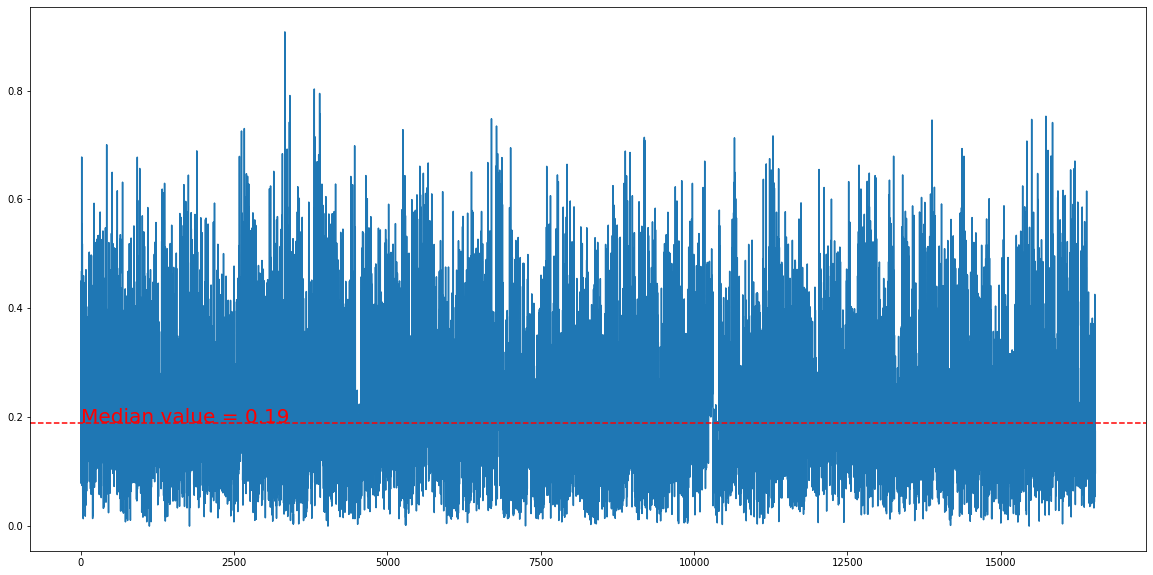

In [57]:
#non spoiler
mediann = non_spoiler_synopsis.Cosine_Similarity.median()
plt.figure(figsize=(20,10))
plt.plot(non_spoiler_synopsis.Cosine_Similarity)
plt.axhline(y=non_spoiler_synopsis.Cosine_Similarity.median(),color="r", linestyle='--',)
plt.text(1,mediann, f"Median value = {mediann:.2f}", color='r',fontsize=20)

Text(1, 0.299406963279483, 'Median value = 0.30')

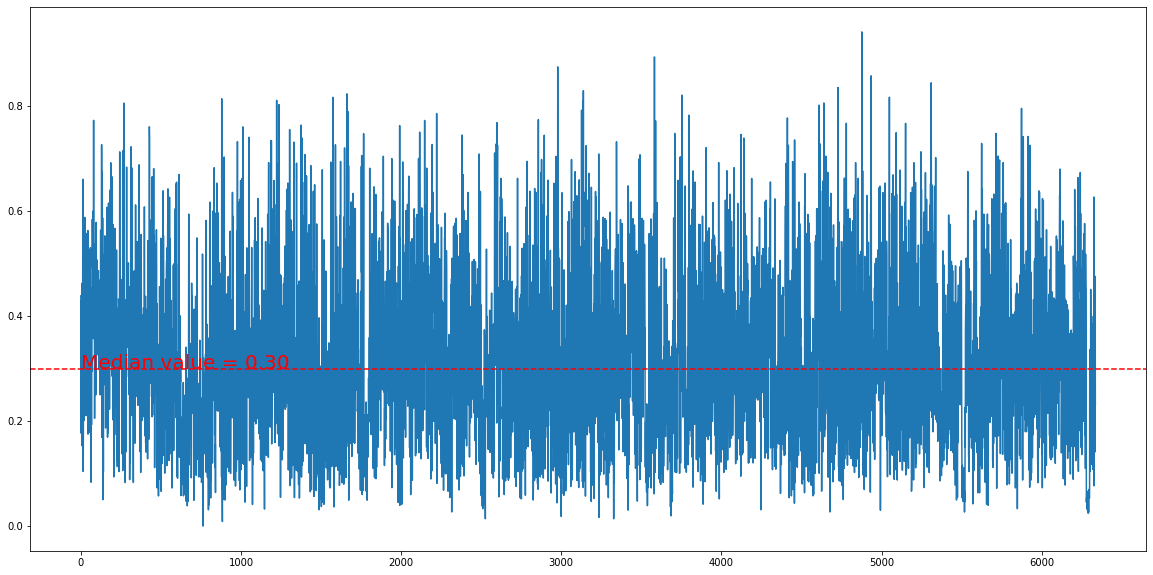

In [58]:
#spoiler

mediann = spoilers_synopsis.Cosine_Similarity.median()
plt.figure(figsize=(20,10))
plt.plot(spoilers_synopsis.Cosine_Similarity)
plt.axhline(y=spoilers_synopsis.Cosine_Similarity.median(),color="r", linestyle='--',)
plt.text(1,mediann, f"Median value = {mediann:.2f}", color='r',fontsize=20)

From the above graphs we can see that for non spoilers data, the median cosine similarity value is around 19 and for spoilers
data this value is around 30. But can we consider similarity as a feature to be included in identifying a review as
a spoiler or not? To verify this we can perform Hypothesis testing. 

# Hypothesis Testing

The above mentioned assumptions can be concluded using Hypothesis testing. 

lets verify whether similarity score can be considered as a feature to identify whether a review a spoiler or not. 


Null hypothesis (H0): there is no significant difference between the text similarity scores of reviews that contain spoilers 
and those that do not.

Alternative hypothesis (H1): there is a significant difference between the text similarity scores of reviews that contain 
spoilers and those that do not.

Alpha: 0.05

In [59]:
#Mann-Whitney U Test

In [60]:
mannwhitneyu(spoilers_synopsis.Cosine_Similarity,non_spoiler_synopsis.Cosine_Similarity,alternative="two-sided")

MannwhitneyuResult(statistic=72045184.0, pvalue=0.0)

Since the p-value is less than 0.05, we can conclude that there is a significant difference in the similarity score between Spoilers dataset and non spoilers dataset allowing us to reject the null hypothesis. 

This means that the distribution of similarity score between spoilers dataset and non spoilers dataset are different and this feature can be used to identify whether a review is a spoiler or not

# Data manupilation in Non spoiler dataset (Outlier Detection)

An Important factor to notice in non spoiler dataset is that, there are reviews in non spoiler dataset that has a high
similarity score yet classified as non spoiler. Let's look at one of those reviews

In [61]:
non_spoiler_synopsis.Cosine_Similarity.argmax()

3327

In [62]:
print(non_spoiler_synopsis.Title.iloc[3327],"\n")
print("the cosine similarity of a review in non spoiler dataset is",non_spoiler_synopsis.Cosine_Similarity.iloc[3327],"\n")
print(non_spoiler_synopsis.Review.iloc[3327])

/title/tt0110413/ 

the cosine similarity of a review in non spoiler dataset is 0.9077978387523011 

This is the first Jean Reno film I saw. After this one, I saw many of his other films as well. BUT THIS ONE IS MY FAVORITE! The role fits him like a glove, and it seems to me to be made only for him. He gives us his emotional best in the film. The other great star in this film that complements him is Natalie Portman who plays her film debut at 12 years of age. Natalie plays the role of Mathilda, Leon's (Jean Reno) neighbour. Her acting is simply phenomenal. But like most child stars (a good example is Macaulay Culkin (Home Alone)) she does not do well as an adult actress. Anyway this IS HER BEST FILM. Now we are going to say something about the super actor called Gary Oldman. He is SUPER! My god I haven't seen anyone act like this before. This guy really gets into the act! This is ALSO HIS BEST FILM. Now when the 3 actors above all give their best, enough is said. Full Plot: Leone "Léon

From a user point of view and from a model point of view, It is important for the model to identify non spoilers
as spoilers than classifying spoiler as non spoilers. If a review is classified as non spoiler but 
contains spoiler(false negative) is bigger problem than classifying a review as spoiler even if it is 
not a spoiler(false positive)

So we are going to set a threshold on similarity score beyond which if there are any reviews, will classify them as
spoilers as that is the priority of this model. 

In [63]:
non_spoiler_synopsis.Cosine_Similarity.describe()

count    16543.000000
mean         0.218163
std          0.133921
min          0.000000
25%          0.114300
50%          0.188936
75%          0.298386
max          0.907798
Name: Cosine_Similarity, dtype: float64

In [64]:
non_spoiler_synopsis[non_spoiler_synopsis.Cosine_Similarity>0.29]

,Review,Title,Spoiler_flag,Synopsis,Cosine_Similarity
2,This movie is not your ordinary Hollywood flic...,/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.450186
11,"Can Hollywood, usually creating things for ent...",/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.385156
13,"""The Shawshank Redemption"" should have won Bes...",/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.468377
14,"One of my favorite movies ever,The Shawshank R...",/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.291248
15,The story of this film takes place over a twen...,/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.677959
...,...,...,...,...,...
16509,Bong Joon-Ho is a director that I knew a littl...,/title/tt0353969/,0,"In October 1986, two women are found raped and...",0.371534
16513,It's 1986 in South Korea. Women's bodies are b...,/title/tt0353969/,0,"In October 1986, two women are found raped and...",0.337382
16514,"1986. In a rural district of South Korea, two ...",/title/tt0353969/,0,"In October 1986, two women are found raped and...",0.301739
16520,There's no other way to say it: this is outsta...,/title/tt0353969/,0,"In October 1986, two women are found raped and...",0.355138


In [65]:
spoilers_synopsis.Cosine_Similarity.median()

0.299406963279483

Now what is the threshold value?

We have decided to consider 30 as the threshold value. There are two reasons:
1) a score of 30 represents 3rd quartile in the non spoiler dataset. Which means 75% of data in non spoiler has a similarity
value less than 30 which makes sense as less value means less spoiler content. This constitutes to 4405 data points 
from a total of 16543

2) The median value of cosine similarity in spoilers dataset is also around 30. Why spoilers dataset? because with this
information we can say that on an average if a review is a spoiler then it has similarity score around 30.

# Doc2Vec

In [66]:
#similarity score using Doc2vec model for better analyzing the relationship between review and plot synopsis

In [67]:
#spoilers data

In [68]:
texts = spoilers_synopsis["Review"].tolist() + spoilers_synopsis["Synopsis"].tolist()
preprocessed_texts = [text.lower().split() for text in texts]

In [69]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(preprocessed_texts)]
model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, epochs=50)

In [70]:
similarities = []
for i in range(len(spoilers_synopsis)):
    review_vec = model.infer_vector(preprocessed_texts[i])
    synopsis_vec = model.infer_vector(preprocessed_texts[i + len(spoilers_synopsis)])
    similarity = model.docvecs.similarity_unseen_docs(model, preprocessed_texts[i], preprocessed_texts[i + len(spoilers_synopsis)], alpha=1, min_alpha=0.0001, steps=5)
    similarities.append(similarity)

# Add similarity scores as a new column to the DataFrame
spoilers_synopsis['doc_similarity'] = similarities

In [71]:
spoilers_synopsis.head()

,Review,Title,Spoiler_flag,Synopsis,Cosine_Similarity,doc_similarity
0,The Shawshank Redemption is written and direct...,/title/tt0111161/,1,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.438682,0.430338
1,"In its Oscar year, Shawshank Redemption (writt...",/title/tt0111161/,1,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.429616,0.254802
2,"Based on a novella by Stephen King, this is be...",/title/tt0111161/,1,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.177022,0.440053
3,The Shawshank Redemption is without a doubt on...,/title/tt0111161/,1,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.429847,0.332315
4,None of the usual otherworld creatures that po...,/title/tt0111161/,1,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.308884,0.355151


In [72]:
spoilers_synopsis.to_excel("spoilers_synopsis_similarity.xlsx")

In [73]:
spoilers_synopsis.doc_similarity.describe()

count    6336.000000
mean        0.315443
std         0.100368
min        -0.086289
25%         0.247151
50%         0.318042
75%         0.385660
max         0.717725
Name: doc_similarity, dtype: float64

In [74]:
#non spoiler

In [75]:
texts = non_spoiler_synopsis["Review"].tolist() + non_spoiler_synopsis["Synopsis"].tolist()
preprocessed_texts = [text.lower().split() for text in texts]

In [77]:
#documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(preprocessed_texts)]
#model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, epochs=50)

In [ ]:
similarities = []
for i in range(len(non_spoiler_synopsis)):
    review_vec = model.infer_vector(preprocessed_texts[i])
    synopsis_vec = model.infer_vector(preprocessed_texts[i + len(non_spoiler_synopsis)])
    similarity = model.docvecs.similarity_unseen_docs(model, preprocessed_texts[i], preprocessed_texts[i + len(non_spoiler_synopsis)], alpha=1, min_alpha=0.0001, steps=5)
    similarities.append(similarity)

# Add similarity scores as a new column to the DataFrame
non_spoiler_synopsis['doc_similarity'] = similarities

In [ ]:
non_spoiler_synopsis.head()

In [92]:
non_spoiler_synopsis.to_excel("non_spoiler_synopsis_similarity.xlsx")

In [78]:
spoilers_synopsis = pd.read_excel("spoilers_synopsis_similarity.xlsx")
non_spoiler_synopsis = pd.read_excel("non_spoiler_synopsis_similarity.xlsx")

In [79]:
non_spoiler_synopsis.doc_similarity.describe()

count    16543.000000
mean         0.229422
std          0.097675
min         -0.187233
25%          0.163865
50%          0.230187
75%          0.294684
max          0.639787
Name: doc_similarity, dtype: float64

Text(1, 0.23018699884414673, 'Median value = 0.23')

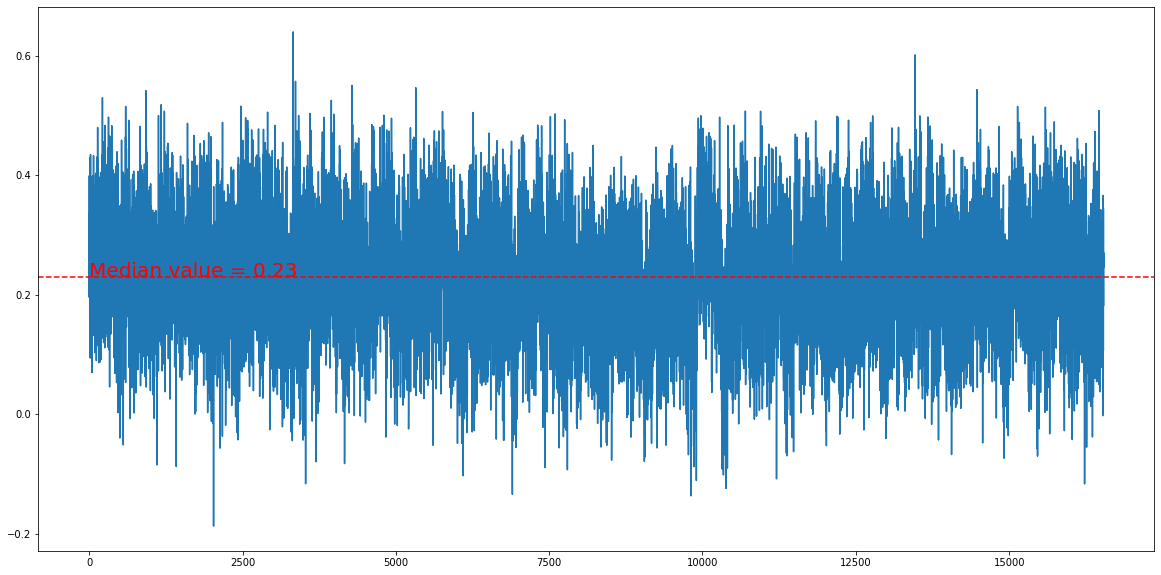

In [82]:
#non spoiler
mediann = non_spoiler_synopsis.doc_similarity.median()
plt.figure(figsize=(20,10))
plt.plot(non_spoiler_synopsis.doc_similarity)
plt.axhline(y=non_spoiler_synopsis.doc_similarity.median(),color="r", linestyle='--',)
plt.text(1,mediann, f"Median value = {mediann:.2f}", color='r',fontsize=20)

Text(1, 0.3162420392036438, 'Median value = 0.32')

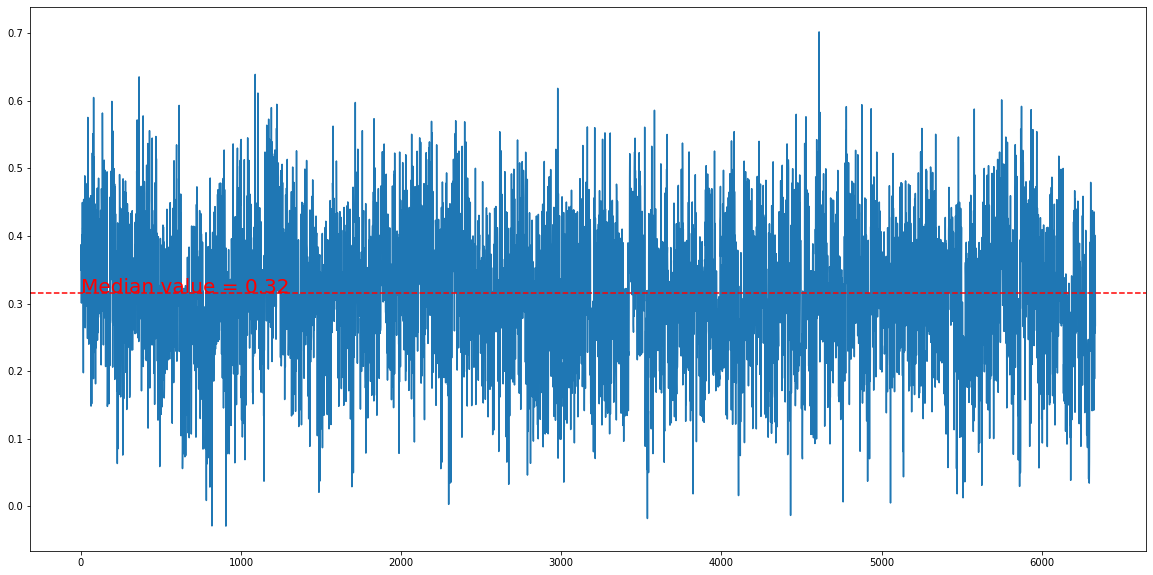

In [83]:
#spoiler

mediann = spoilers_synopsis.doc_similarity.median()
plt.figure(figsize=(20,10))
plt.plot(spoilers_synopsis.doc_similarity)
plt.axhline(y=spoilers_synopsis.doc_similarity.median(),color="r", linestyle='--',)
plt.text(1,mediann, f"Median value = {mediann:.2f}", color='r',fontsize=20)

From the above graphs we can see that for non spoilers data, the median cosine similarity value is around 0.23 and for spoilers
data this value is around 0.31. But can we consider similarity as a feature to be included in identifying a review as
a spoiler or not? To verify this we can perform Hypothesis testing. 

# Hypothesis Testing

The above mentioned assumptions can be concluded using Hypothesis testing. 

lets verify whether similarity score can be considered as a feature to identify whether a review a spoiler or not. 


Null hypothesis (H0): there is no significant difference between the text similarity scores of reviews that contain spoilers 
and those that do not.

Alternative hypothesis (H1): there is a significant difference between the text similarity scores of reviews that contain 
spoilers and those that do not.

Aplha: 0.05

In [80]:
#Mann-Whitney U Test

In [81]:
mannwhitneyu(spoilers_synopsis.doc_similarity,non_spoiler_synopsis.doc_similarity,alternative="two-sided")

MannwhitneyuResult(statistic=76574246.0, pvalue=0.0)

Since the p-value is less than 0.05, we can conclude that there is a significant difference in the similarity score between Spoilers dataset and non spoilers dataset allowing us to reject the null hypothesis. 

This means that the distribution of similarity score between spoilers dataset and non spoilers dataset are different and this feature can be used to identify whether a review is a spoiler or not

# Data manupilation in Non spoiler dataset (Outlier Detection)

An Important factor to notice in non spoiler dataset is that, there are reviews in non spoiler dataset that has a high
similarity score yet classified as non spoiler. Let's look at one of those reviews

In [82]:
non_spoiler_synopsis.doc_similarity.argmax()

3327

In [83]:
print(non_spoiler_synopsis.Title.iloc[3327],"\n")
print("the Doc similarity of a review in non spoiler dataset is",non_spoiler_synopsis.doc_similarity.iloc[3327],"\n")
print(non_spoiler_synopsis.Review.iloc[3327])

/title/tt0110413/ 

the Doc similarity of a review in non spoiler dataset is 0.6397867202758789 

This is the first Jean Reno film I saw. After this one, I saw many of his other films as well. BUT THIS ONE IS MY FAVORITE! The role fits him like a glove, and it seems to me to be made only for him. He gives us his emotional best in the film. The other great star in this film that complements him is Natalie Portman who plays her film debut at 12 years of age. Natalie plays the role of Mathilda, Leon's (Jean Reno) neighbour. Her acting is simply phenomenal. But like most child stars (a good example is Macaulay Culkin (Home Alone)) she does not do well as an adult actress. Anyway this IS HER BEST FILM. Now we are going to say something about the super actor called Gary Oldman. He is SUPER! My god I haven't seen anyone act like this before. This guy really gets into the act! This is ALSO HIS BEST FILM. Now when the 3 actors above all give their best, enough is said. Full Plot: Leone "Léon" M

From a user point of view and from a model point of view, It is important for the model to identify non spoilers
as spoilers than classifying spoiler as non spoilers. If a review is classified as non spoiler but 
contains spoiler(false negative) is bigger problem than classifying a review as spoiler even if it is 
not a spoiler(false positive)

So we are going to set a threshold on similarity score beyond which if there are any reviews, will classify them as
spoilers as that is the priority of this model. 

In [88]:
non_spoiler_synopsis.doc_similarity.describe()

count    16543.000000
mean         0.229422
std          0.097675
min         -0.187233
25%          0.163865
50%          0.230187
75%          0.294684
max          0.639787
Name: doc_similarity, dtype: float64

In [89]:
non_spoiler_synopsis[non_spoiler_synopsis.doc_similarity>0.29]

,Review,Title,Spoiler_flag,Synopsis,Cosine_Similarity,doc_similarity
2,This movie is not your ordinary Hollywood flic...,/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.450186,0.399124
5,I've lost count of the number of times I have ...,/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.182805,0.337536
11,"Can Hollywood, usually creating things for ent...",/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.385156,0.297641
13,"""The Shawshank Redemption"" should have won Bes...",/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.468377,0.429060
14,"One of my favorite movies ever,The Shawshank R...",/title/tt0111161/,0,"In 1947, Andy Dufresne ( Tim Robbins ), a bank...",0.291248,0.396765
...,...,...,...,...,...,...
16517,In every anime trio there's a serious one with...,/title/tt0353969/,0,"In October 1986, two women are found raped and...",0.094035,0.322971
16518,A beautifully composed movie that sucks us int...,/title/tt0353969/,0,"In October 1986, two women are found raped and...",0.172020,0.317878
16527,Writer/director Joon-ho Bong (The Host) presen...,/title/tt0353969/,0,"In October 1986, two women are found raped and...",0.147464,0.311064
16533,Based on an actual series of murders in South ...,/title/tt0353969/,0,"In October 1986, two women are found raped and...",0.425614,0.366091


In [90]:
spoilers_synopsis.doc_similarity.median()

0.3162420392036438

Now what is the threshold value?

We have decided to consider 30 as the threshold value. There are two reasons:
1) a score of 30 represents 3rd quartile in the non spoiler dataset. Which means 75% of data in non spoiler has a similarity
value less than 30 which makes sense as less value means less spoiler content. This constitutes to 4405 data points 
from a total of 16543

2) The median value of Doc similarity in spoilers dataset is also around 30. Why spoilers dataset? because with this
information we can say that on an average if a review is a spoiler then it has similarity score around 30.

# hypothesis testing to support the above statement

Null hypothesis (H0): The null hypothesis would be that there is 
no relationship between the similarity score of a movie review and whether it contains spoilers or not

Alternative hypothesis (H1): The alternative hypothesis would be that there is a relationship, and specifically, that a similarity score of more than 30 indicates that the review is likely to contain spoilers.

Alpha: 0.05

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

In [3]:
df1 = pd.read_excel("non_spoiler_synopsis_similarity.xlsx")
df2 = pd.read_excel("spoilers_synopsis_similarity.xlsx")

In [4]:
df = pd.concat([df1,df2])

In [7]:
df.drop("Unnamed: 0",inplace=True,axis=1)

In [8]:
df.shape

(22879, 6)

In [9]:
group_high = df[df['doc_similarity'] > 0.30]
group_low = df[df['doc_similarity'] <= 0.30]

In [13]:
high_spoilers =len(group_high[group_high.Spoiler_flag==1])
high_non_spoilers = len(group_high) - high_spoilers
low_spoilers = len(group_low[group_low.Spoiler_flag==1])
low_non_spoilers = len(group_low) - low_spoilers

In [16]:
contingency_table = np.array([[high_spoilers, high_non_spoilers], [low_spoilers, low_non_spoilers]])


In [17]:
contingency_table

array([[ 3568,  3880],
       [ 2768, 12663]])

In [19]:
chi2, p, dof, expected = chi2_contingency(contingency_table)

# print the results
print(f"Chi-Squared: {chi2}")
print(f"p-value: {p}")

Chi-Squared: 2251.4151695536643
p-value: 0.0


In [20]:
#since the p-value is less than 0.05 we can reject the null hypothesis.

# Building the Final Dataset

Since we statistically proven that reviews with similarity score more than 30 can be considered as Spoilers, we will now
add all the non spoilers with score more than 30 as a part of spoilers data

In [47]:
new_spoilers = df1[df1.doc_similarity>0.30]

In [51]:
new_spoilers.Spoiler_flag=1

C:\Users\noahr\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [54]:
final_spoilers = pd.concat([df2,new_spoilers])

In [55]:
final_spoilers.shape

(10216, 7)

In [58]:
final_non_spoiler = df1[df1.doc_similarity<=0.30]

In [59]:
final_non_spoiler.shape

(12663, 7)

In [60]:
final_df = pd.concat([final_spoilers,final_non_spoiler], ignore_index=True).sample(frac=1)

In [61]:
final_df.drop("Unnamed: 0",inplace=True,axis=1)

In [62]:
final_df

,Review,Title,Spoiler_flag,Synopsis,Cosine_Similarity,doc_similarity
21866,The conclusion to the series hits some of the ...,/title/tt1201607/,0,After burying Dobby at the garden of the Shell...,0.158318,0.106248
7319,The Lion King was pretty much my favourite mov...,/title/tt0110357/,1,The Lion King takes place in the Pride Lands o...,0.197134,0.404854
15075,"OK, perhaps there is truth in the saying ""lost...",/title/tt0364569/,0,"The film begins in medias res, with the silhou...",0.115011,0.219557
3203,Top Gun has been an 80's staple since it first...,/title/tt1745960/,1,"Over three decades after his time at TOPGUN, C...",0.423765,0.262304
10801,I'll keep this brief: This is simply one of th...,/title/tt0060196/,0,The film tells the story of three men who purs...,0.084172,0.156379
...,...,...,...,...,...,...
16050,Let's be honest: is this film really worthy of...,/title/tt0211915/,0,Amelie Poulain (Audrey Tautou) is the only chi...,0.112264,0.048846
12029,Paul Edgecomb (Tom Hanks) is the lead guard on...,/title/tt0120689/,0,The movie opens with a group of people running...,0.270954,0.230906
20358,This is undoubtedly the greatest film ever. Th...,/title/tt0031381/,0,"The film opens in Tara, a cotton plantation ow...",0.106873,0.180562
22815,"No, this is not an horrible movie and I did no...",/title/tt0046268/,0,"1950, in the very isolated town of Las Piedras...",0.174709,0.272613


In [63]:
final_df.to_excel("final_df.xlsx")